# Project : Detect and Track vehicles on a video feed

Author: Mouad HADJI, January 2018, the 15th

The goal here is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

## 1. Import packages

In this section, we import the packages we will use throughout the project. If there is the need for other packages, we will load them later.

In [1]:
import os
import sys
import glob
import cv2
import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Load The Data

We first load the training images (vehicle and non-vehicle images) that will allow us to train, measure the performance and evaluate our vehicle detection classifier.

In [2]:
project_path = os.path.join(os.environ["HOME"], "sdcnd/vehicle_detection")
data_path = os.path.join(project_path, "data")

In [3]:
vehicles_path = glob.glob(os.path.join(data_path, "vehicles/**/*.png"))
non_vehicles_path = glob.glob(os.path.join(data_path, "non-vehicles/**/*.png"))

In [4]:
vehicles = [cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) for img_path in vehicles_path]
non_vehicles = [cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) for img_path in non_vehicles_path]

In [106]:
print("Shape of Images: " + str(vehicles[0].shape))

Shape of Images: (64, 64, 3)


In [5]:
print("Count of vehicle Images: " + str(len(vehicles)))
print("Count of non-vehicle Images: " + str(len(non_vehicles)))

Count of vehicle Images: 8792
Count of non-vehicle Images: 8968


In [6]:
def compare_images(two_images, two_labels, figsize=(10, 10)):
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    axes[0].imshow(two_images[0])
    axes[0].set_title(two_labels[0])
    axes[1].imshow(two_images[1])
    axes[1].set_title(two_labels[1])

In [7]:
def plot_figures(series, n_row=1, n_col=2, figsize=(15, 5), cmap=None, save=False, filename=''):

    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    n_images = n_row*n_col
    series = series[:n_images]
    
    for i, serie in enumerate(series):
        plt.subplot(n_row, n_col, i+1)
        plt.plot(serie)
        plt.xticks([])
        plt.yticks([])   
        if save:
            plt.savefig(os.path.join(output_path, filename + '_' + str(i) + '.png'))
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [8]:
def show_images(images, n_row=1, n_col=2, figsize=(12, 3), cmap=None, save=False, filename=''):

    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    n_images = n_row*n_col
    images = images[:n_images]
    
    for i, image in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(image) if cmap is None else plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])   
        if save:
            plt.savefig(os.path.join(output_path, filename + '_' + str(i) + '.png'))
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [9]:
def plot_hist(channel1_hist, channel2_hist, channel3_hist, bin_centers, figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplot(131)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('Channel 1 Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('Channel 2 Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel3_hist[0])
    plt.xlim(0, 256)
    plt.title('Channel 3 Histogram')
    fig.tight_layout()

In [10]:
idx_vehicles = list(np.random.randint(len(vehicles), size=6))
idx_non_vehicles = list(np.random.randint(len(non_vehicles), size=6))

In [11]:
test_vehicles = [vehicles[idx] for idx in idx_vehicles]
test_nonvehicles = [non_vehicles[idx] for idx in idx_non_vehicles]

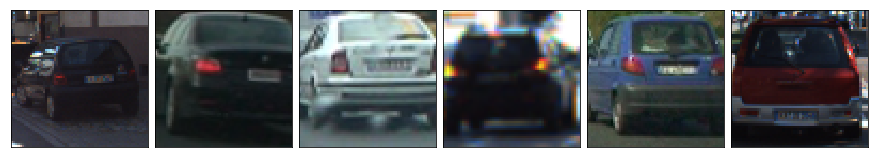

In [12]:
show_images(test_vehicles, n_row=1, n_col=6)

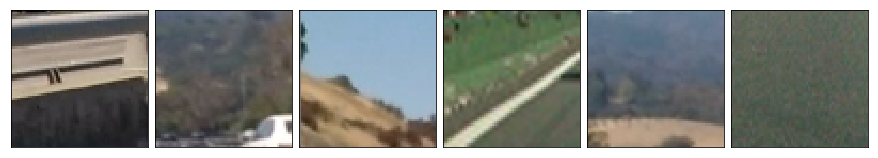

In [13]:
show_images(test_nonvehicles, n_row=1, n_col=6)

## 3. Feature Engineering

In [14]:
params = {
    # Bin spatial parameters
    "SPATIAL_SIZE":(16, 16),
    # Histogram parameters
    "HIST_BINS":32,
    "HIST_RANGE":(0,256),
    # HOG parameters
    "COLOR_SPACE":'YCrCb',
    "ORIENT":8,
    "PIX_PER_CELL":8,
    "CELL_PER_BLOCK":2,
    "HOG_CHANNEL":"ALL",
    # Extracting featurs
    "SPAT_FEAT":True,
    "HIST_FEAT":True,
    "HOG_FEAT":True,
}

Reminder :

`ORIENT` : The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

`PIX_PER_CELL` : The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

`CELL_PER_BLOCK` : The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

In [15]:
class FeatureExtraction():
    
    def __init__(self, params):
        self.size = params["SPATIAL_SIZE"]
        self.hist_bins = params["HIST_BINS"]
        self.hist_range = params["HIST_RANGE"]
        self.cspace = params["COLOR_SPACE"]
        self.orient = params["ORIENT"]
        self.pix_per_cell = params["PIX_PER_CELL"]
        self.cell_per_block = params["CELL_PER_BLOCK"]
        self.hog_channel = params["HOG_CHANNEL"]
        self.spatial_feat = params["SPAT_FEAT"]
        self.hist_feat = params["HIST_FEAT"]
        self.hog_feat = params["HOG_FEAT"]
        
    def convert_color(self, img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'BGR2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        
    def convert_img(self, img, color_space="RGB"):
        # Convert image to new color space (if specified)
        convert_dict = {'HLS':cv2.COLOR_RGB2HLS, 'HSV':cv2.COLOR_RGB2HSV, 'LUV':cv2.COLOR_RGB2LUV,
                        'YUV':cv2.COLOR_RGB2YUV, 'YCrCb':cv2.COLOR_RGB2YCrCb}
        if color_space!='RGB':
            return cv2.cvtColor(img, convert_dict[color_space])
        else:
            return np.copy(img)        
    
    def bin_spatial(self, img, size=(32, 32)):
        #new_img = self.convert_img(img, color_space=color_space)
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        
        ## generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
        # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    
    
    def get_hog_features(self, img, orient=None, pix_per_cell=None, cell_per_block=None, vis=False, feature_vec=True):
        
        orient = self.orient if orient is None else orient
        pix_per_cell = self.pix_per_cell if pix_per_cell is None else pix_per_cell
        cell_per_block = self.cell_per_block if cell_per_block is None else cell_per_block
        
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
        
    def extract_features(self, img):
        
        feature_image = self.convert_img(img, color_space=self.cspace)
        features = []
        
        if self.hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                        self.orient, self.pix_per_cell, self.cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:,:,self.hog_channel],
                                                     self.orient, self.pix_per_cell, self.cell_per_block,
                                                     vis=False, feature_vec=True)
            features.append(hog_features)
                
        if self.spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial(feature_image, self.size)
            features.append(spatial_features)

        if self.hist_feat:
            # Apply color_hist() to get histogram of colors
            _, _, _, _, hist_features = self.color_hist(feature_image, nbins=self.hist_bins, bins_range=self.hist_range)
            features.append(hist_features)

        return np.concatenate(features)

In [16]:
FE = FeatureExtraction(params)

### Spatial Color Binning

Raw pixel values can be quite useful to include in our feature vector in searching for cars.

While it could be cumbersome to include three color channels of a full resolution image, one can perform spatial binning on an image and still retain enough information to help in finding vehicles.

In [17]:
test_vehicles_color_bins = [FE.bin_spatial(img) for img in test_vehicles]
test_nonvehicles_color_bins = [FE.bin_spatial(img) for img in test_nonvehicles]

In [18]:
test_vehicles_color_bins[0].shape

(3072,)

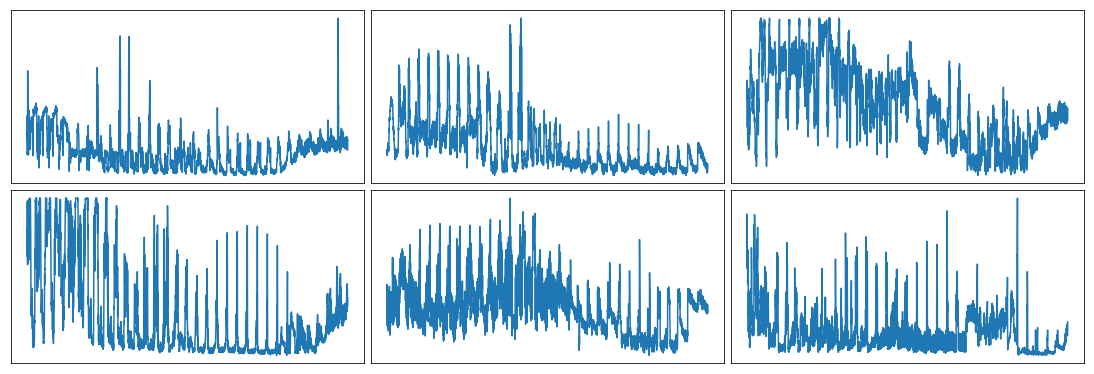

In [19]:
plot_figures(test_vehicles_color_bins, n_row=2, n_col=3)

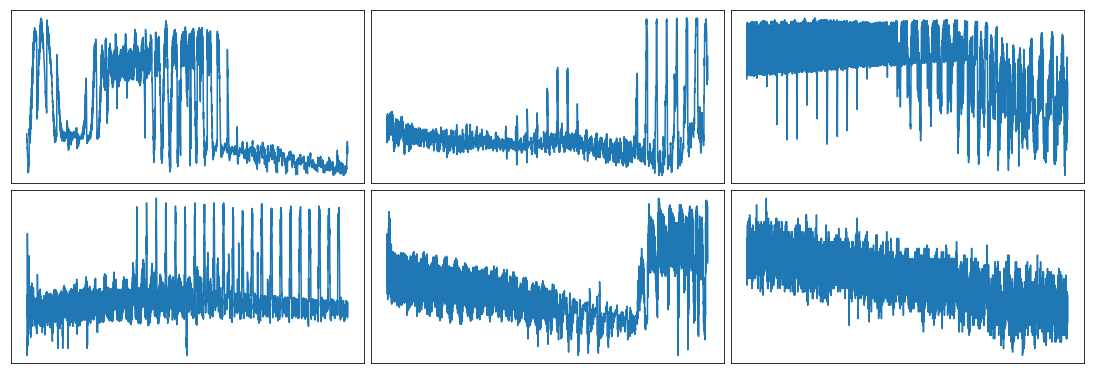

In [20]:
plot_figures(test_nonvehicles_color_bins, n_row=2, n_col=3)

### Histograms of Colors

Another way to use color features that is more flexible than template matching or spatial binning is to use histogram of colors. Indeed, this technique is more robust to changes and appearences. Objects athat appear on different aspects and orientations can be matched.

In [21]:
test_vehicles_color_hist = [FE.color_hist(img) for img in test_vehicles]
test_nonvehicles_color_hist = [FE.color_hist(img) for img in test_nonvehicles]

In [22]:
channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features = test_vehicles_color_hist[0]

In [23]:
hist_features.shape

(96,)

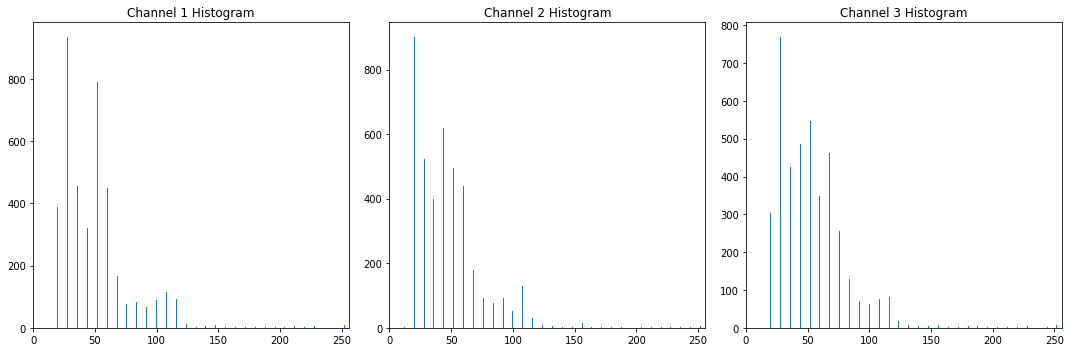

In [24]:
plot_hist(channel1_hist, channel2_hist, channel3_hist, bin_centers)

In [25]:
channel1_hist, channel2_hist, channel3_hist, bin_centers, _ = test_nonvehicles_color_hist[0]

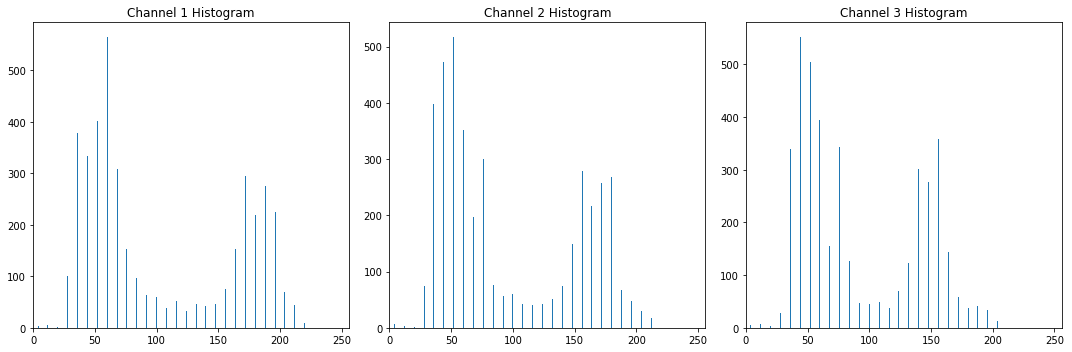

In [26]:
plot_hist(channel1_hist, channel2_hist, channel3_hist, bin_centers)

### Using Histogram of Oriented Gradient (HOG) features

Indeed, the gradients of an image will help to identify the structures within the image. Unless color feature extraction technique, this one is robust to change of colors which can obviously happen with vehicles. The gradient is able to capture the edges of the shape of the car. We use a modified version that averages the gradients across multiple cells to account for some possible noise in the image.

The `scikit-image` package has a built in function to extract Histogram of Oriented Gradient features.

In [27]:
test_vehicles_hog = [FE.get_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), vis=True) for img in test_vehicles]
test_nonvehicles_hog = [FE.get_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), vis=True) for img in test_nonvehicles]

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [28]:
vehicles_hog_features = [item[0] for item in test_vehicles_hog]
nonvehicles_hog_features = [item[0] for item in test_nonvehicles_hog]

In [29]:
vehicles_hog_features[0].shape

(1568,)

In [30]:
nonvehicles_hog_features[0].shape

(1568,)

In [31]:
vehicles_hog_images = [item[1] for item in test_vehicles_hog]
nonvehicles_hog_images = [item[1] for item in test_nonvehicles_hog]

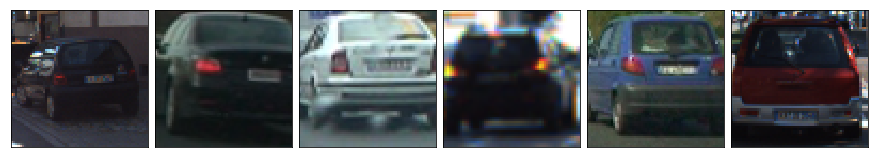

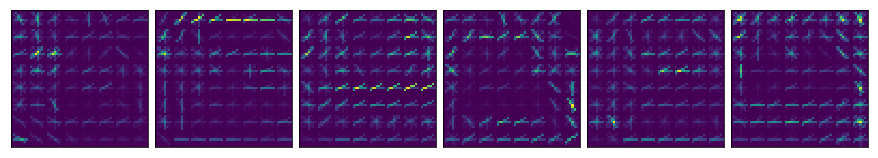

In [32]:
show_images(test_vehicles, n_col=6)
show_images(vehicles_hog_images, n_col=6)

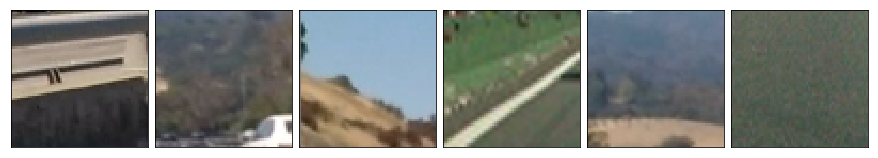

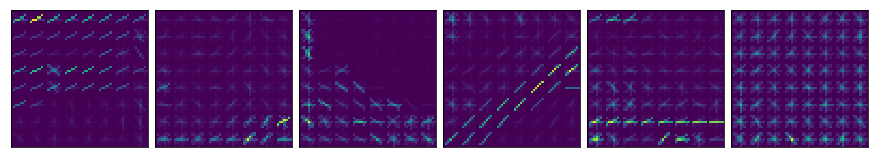

In [33]:
show_images(test_nonvehicles, n_col=6)
show_images(nonvehicles_hog_images, n_col=6)

The HOG visualization is not actually the feature vector, but rather, a representation that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell.

If you look at the features output, you'll find it's an array of shape `PIX_PER_CELL`×`PIX_PER_CELL`×`CELL_PER_BLOCK`×`CELL_PER_BLOCK`×`ORIENT`. This corresponds to the fact that a grid of `PIX_PER_CELL`×`PIX_PER_CELL` blocks were sampled, with `CELL_PER_BLOCK`×`CELL_PER_BLOCK` cells in each block and `ORIENT` orientations per cell. This array is transformed into a feature vector using features.ravel(), which yields, in this case, a one dimensional array.

### Combining and Normalizing all features

Now that we have got several feature extraction methods in out toolkit, we're almost ready to train a classifier, but first, as in any machine learning application, we need to combine and normalize our data by using the sklearn `StandardScaler()` method to accomplish this task.

In [34]:
vehicles_features = [FE.extract_features(img) for img in vehicles]
nonvehicles_features = [FE.extract_features(img) for img in non_vehicles]

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [35]:
y_vehicles = list(np.ones(len(vehicles_features)))
y_non_vehicles = list(np.zeros(len(nonvehicles_features)))

In [36]:
X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)

In [37]:
X.shape

(17760, 5568)

In [38]:
y = np.hstack((y_vehicles, y_non_vehicles))

In [39]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## 4. Training Model

In [73]:
rf_raw = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

In [74]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [75]:
def train_model(X_train, X_test, y_train, y_test, sklearn_model):
    """
    Trains the classifier `sklearn_model`. 
    """
    sklearn_model.fit(X_train, y_train)
    accuracy = sklearn_model.score(X_test, y_test)
    
    return sklearn_model, accuracy

In [76]:
rf, accuracy_rf = train_model(X_train, X_test, y_train, y_test, rf_raw)

In [77]:
accuracy_rf

0.99042792792792789

In [78]:
n_predict=10

In [79]:
print('Model predicts: ', rf.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])

Model predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
Actual labels:   [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]


## 5. Implementing sliding windows for detection

In [81]:
class Slider():
    
    def __init__(self, FeatureEng):
        self.FE = FeatureEng
        
    # Draw boxes on an image
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        imcopy = np.copy(img)
        for bbox in bboxes:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        return imcopy
    
    # Define a function that takes an image, start and stop positions in both x and y,
    # window size (x and y dimensions), and overlap fraction (for both x and y)
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None],
                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    # Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
    def search_windows(self, img, windows, clf, scaler):

        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = self.FE.extract_features(test_img)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows
    
    def run(self, img, clf, scaler,
            x_start_stop=[None, None], y_start_stop = [360, 700],
            xy_window=(64, 64), xy_overlap = (0.75, 0.75)):
        windows = self.slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
        on_windows = self.search_windows(img, windows, clf, scaler)
        img_withboxes = self.draw_boxes(img, on_windows)
        return on_windows, img_withboxes
    
    def run_new(self, img, clf, scaler, window_sizes,
                x_start_stop=[None, None], y_start_stop = [360, 700], xy_overlap = (0.75, 0.75)):
        windows = []
        for window_size in window_sizes:
            xy_window = (window_size, window_size)
            current_windows = self.slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
            windows += current_windows
        on_windows = self.search_windows(img, windows, clf, scaler)
        img_withboxes = self.draw_boxes(img, on_windows)
        return on_windows, img_withboxes

In [82]:
SL = Slider(FE)

In [83]:
test_images_path = glob.glob(os.path.join(project_path, "test_images/*.jpg"))

In [84]:
test_images = [cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) for img_path in test_images_path]

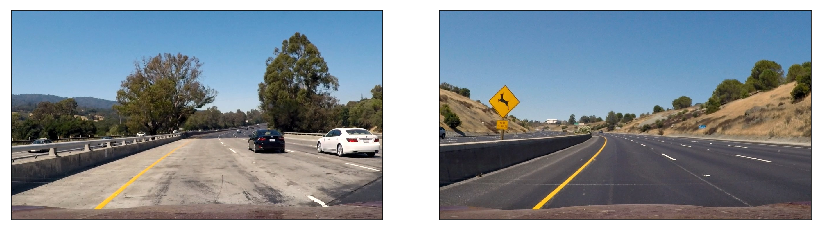

In [85]:
show_images(test_images)

In [86]:
test_image = test_images[0]

In [94]:
xy_window = (64, 64)
window_sizes = [64, 96, 128]
xy_overlap = (0.85, 0.85)
y_start_stop = [360, 700]

In [95]:
windows = SL.slide_window(test_image, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)

In [96]:
on_windows = SL.search_windows(test_image, windows, rf, X_scaler)

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [97]:
test_image_withboxes = SL.draw_boxes(test_image, on_windows)

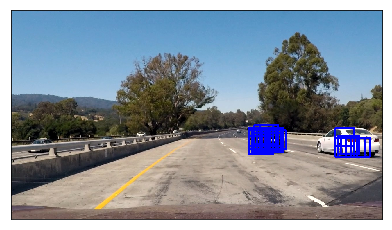

In [98]:
show_images([test_image_withboxes], n_col=1)

In [99]:
test_images_withboxes = [SL.run(img, rf, X_scaler, y_start_stop = y_start_stop,
            xy_window=xy_window, xy_overlap = xy_overlap) for img in test_images]

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


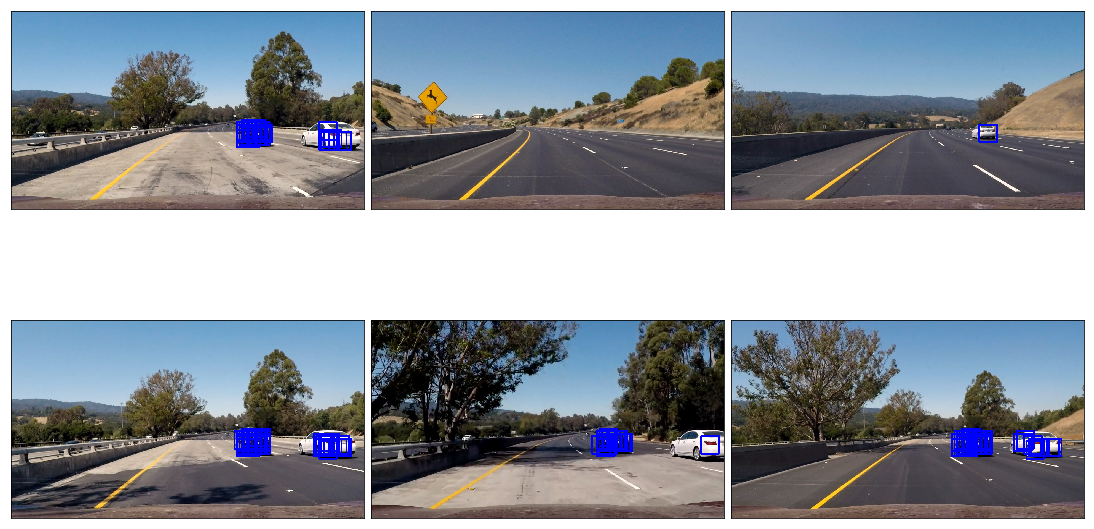

In [100]:
show_images([item[1] for item in test_images_withboxes], n_row=2, n_col=3, figsize=(15,10))

In [101]:
test_images_withboxes_new = [SL.run_new(img, rf, X_scaler, window_sizes = window_sizes,
                                y_start_stop = y_start_stop, xy_overlap = xy_overlap) for img in test_images]

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


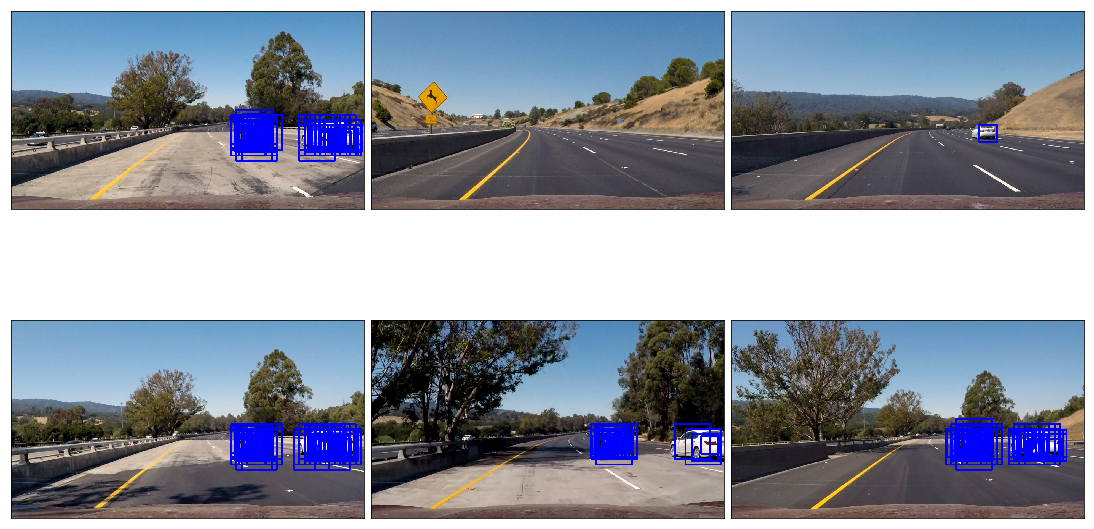

In [102]:
show_images([item[1] for item in test_images_withboxes_new], n_row=2, n_col=3, figsize=(15,10))

In [107]:
on_windows = [item[0] for item in test_images_withboxes_new]

# 6. Create Heat Map

In [108]:
class Heater():

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def run(self, img, box_list):
        # Read in image similar to one shown above 
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = self.add_heat(heat, box_list)
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img, heatmap

In [109]:
Hr = Heater()

In [110]:
draw_images = [Hr.run(img, wdw)[0] for img, wdw in zip(test_images, on_windows)]

In [111]:
heat_images = [Hr.run(img, wdw)[1] for img, wdw in zip(test_images, on_windows)]

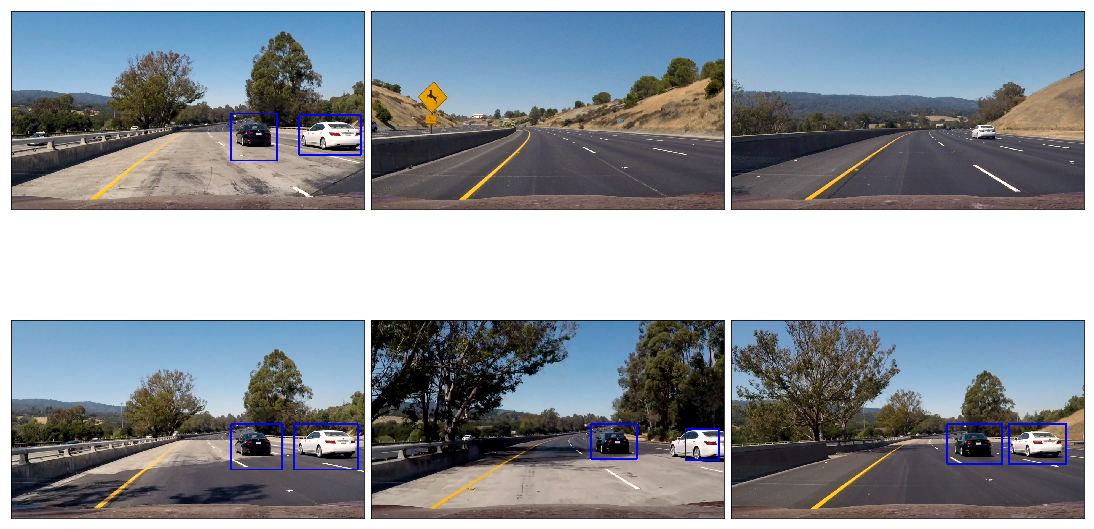

In [112]:
show_images(draw_images, n_row=2, n_col=3, figsize=(15,10))

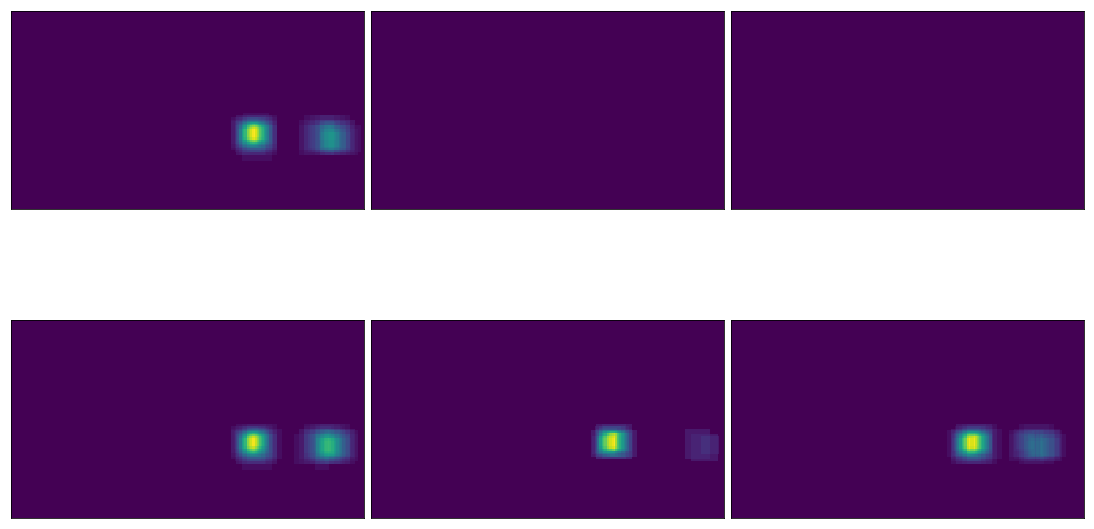

In [113]:
show_images(heat_images, n_row=2, n_col=3, figsize=(15,10))

## 7. Improving with Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function `find_cars` that's able to both extract features and make predictions.

The `find_cars` only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a `cells_per_step = 2` would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [114]:
orient = FE.orient
pix_per_cell = FE.pix_per_cell
cell_per_block = FE.cell_per_block
spatial_size = FE.size
hist_bins = FE.hist_bins

In [123]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def run_efficient(img, clf, scaler, window = 64, scale=1.5, cells_per_step=1, y_start_stop=[350, 656]):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    ystart, ystop = y_start_stop
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = FE.convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = FE.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = FE.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = FE.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = FE.bin_spatial(subimg, size=spatial_size)
            _, _, _, _, hist_features = FE.color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            combined_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = scaler.transform(combined_features)    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255),6) 
                
    #return draw_img
    return car_windows

In [124]:
test_images_car_windows_eff = [run_efficient(img, rf, X_scaler) for img in test_images]

/Users/mhadji/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [125]:
test_images_withboxes_eff = [SL.draw_boxes(test_image, on_windows) for test_image, on_windows in zip(test_images, test_images_car_windows_eff)]

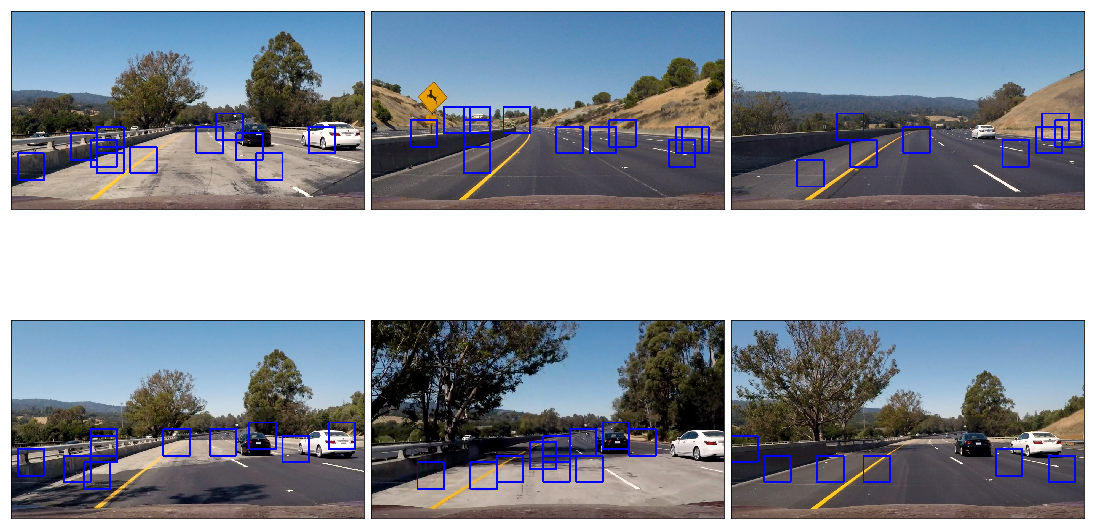

In [128]:
show_images(test_images_withboxes_eff, n_row=2, n_col=3, figsize=(15,10))